# PGGAN MNIST

This notebook is for implementing `Progressive Growing Generative Adversarial Network(PGGAN)` from the paper [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os
from skimage.transform import resize

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters


In [3]:
algorithm = 'PGGAN_MNIST'

img_size = 28

n_latent = 512

beta1 = 0
beta2 = 0.99

learning_rate_g = 0.00005
learning_rate_d = 0.00001

show_result_epoch = 1

# batch_list = [64, 64, 32, 32]
# epoch_list = [10, 15, 20, 25]
# size_list = [4, 8, 16, 32]
# channel_list = [64, 128, 256, 512]

batch_list = [32, 32, 16]
epoch_list = [15, 25, 35]
size_list = [8, 16, 32]
channel_list = [16, 32, 64]

# batch_list = [32, 32, 32, 32, 32, 32, 32, 32]
# epoch_list = [10, 10, 10, 10, 10, 10, 10, 10]
# size_list = [4, 8, 12, 16, 20, 24, 28, 32]
# channel_list = [32, 32, 64, 64, 128, 128, 256, 256]

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_PGGAN_MNIST/model/model" 

# WGAN_GP Parateter
n_critic = 1
d_lambda = 10 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Build Graph

In [6]:
class PGGAN():
    def __init__(self, stage):
        self.stage = stage
        self.channel_list = channel_list
        
        self.x = tf.placeholder(tf.float32, shape=[None, size_list[stage], size_list[stage], 1], name='x_'+str(stage))
        self.x_normalize = (tf.cast(self.x, tf.float32) - (1.0/2)) / (1.0/2)

        self.z = tf.placeholder(tf.float32, shape=[None, n_latent], name='z_'+str(stage))
        
        self.alpha = tf.placeholder(tf.float32, shape=[1])
        self.batch_size = tf.placeholder(tf.float32)
        
        self.is_training = tf.placeholder(tf.bool, name='is_training_'+str(stage))

        self.d_loss, self.g_loss, self.G = self.GAN(self.x_normalize, self.z, self.is_training) 

        # optimization
        self.trainable_vars = tf.trainable_variables()

        self.trainable_vars_d = [var for var in self.trainable_vars if var.name.startswith('Discriminator' + str(self.stage))]
        self.trainable_vars_g = [var for var in self.trainable_vars if var.name.startswith('Generator' + str(self.stage))]
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
#             self.train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(self.d_loss, var_list=self.trainable_vars_d)
#             self.train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(self.g_loss, var_list=self.trainable_vars_g)

            optimizer_d = tf.train.AdamOptimizer(learning_rate_d)
            gvs_d = optimizer_d.compute_gradients(self.d_loss, var_list=self.trainable_vars_d)
            capped_gvs_d = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs_d]
            self.train_step_d = optimizer_d.apply_gradients(capped_gvs_d)
            
            optimizer_g = tf.train.AdamOptimizer(learning_rate_g)
            gvs_g = optimizer_g.compute_gradients(self.g_loss, var_list=self.trainable_vars_g)
            capped_gvs_g = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs_g]
            self.train_step_g = optimizer_g.apply_gradients(capped_gvs_g)

    def GAN(self, x, z, is_training):
        # Generator
        G, mini_std = self.Generator(z, is_training)

        # Discriminator
        D_logit_real, D_out_real = self.Discriminator(x, mini_std, is_training)
        D_logit_fake, D_out_fake = self.Discriminator(G, mini_std, is_training, reuse=True)

        # get loss 
        ########################################### WGAN GP ###########################################
        eps = tf.random_uniform(shape=tf.shape(x),minval=0.0, maxval=1.0)       
        x_hat = (eps * x) + ((1-eps) * G)
        D_hat, _ = self.Discriminator(x_hat, mini_std, is_training, reuse=True)
        grad = tf.gradients(D_hat, [x_hat])[0]
        GP = d_lambda * tf.square(tf.norm(grad, ord=2) - 1)

        d_loss = -tf.reduce_mean(D_logit_real) + tf.reduce_mean(D_logit_fake) + GP #+ 0.001*tf.reduce_mean(tf.square(D_logit_real))
        g_loss = -tf.reduce_mean(D_logit_fake) 
        ###############################################################################################
    
        return d_loss, g_loss , G
    
    # Pixel Normalization
    def pixel_norm(self, x, epsilon=1e-8):
        return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + epsilon)
    
    # Minibatch Standard Deviation
    def minibatch_std(self, x):
        # Compute Standard Deviation over minibatch
        _, batch_std = tf.nn.moments(x, axes=[0], keep_dims=True)
        
        # Average all features
        feature_avg = tf.reduce_mean(batch_std, axis=-1, keepdims=True)
        
        # Replicate the value to concatenate it over the minibatch
        out = tf.tile(feature_avg, multiples=[self.batch_size, 1, 1, 1])
        
        return out

    def conv_block_g(self, x, num_channel, network_name):
        #h_enc = tf.layers.conv2d(x, filters=num_channel, kernel_size=1, strides=1, padding='SAME', name=network_name+'_enc')
        
        h1 = tf.layers.conv2d(x, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
        h1 = tf.nn.leaky_relu(self.pixel_norm(h1))  
            
        #h2 = tf.layers.conv2d(h1, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
        #h2 = tf.nn.leaky_relu(self.pixel_norm(h2))  
            
        #h3 = tf.layers.conv2d(h2, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_3')
        #h3 = tf.nn.leaky_relu(self.pixel_norm(h3) + self.pixel_norm(h_enc))
        #h3 = tf.nn.leaky_relu(self.pixel_norm(h3))

#         h4 = tf.layers.conv2d(h3, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_4')
#         h4 = tf.nn.leaky_relu(self.pixel_norm(h4) + h_enc)  
        
        return h1

    
    def conv_block_d(self, x, num_channel, network_name):
        h1 = tf.layers.conv2d(x, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
        h1 = tf.nn.leaky_relu(h1)
        
        h2 = tf.layers.conv2d(h1, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
        h2 = tf.nn.leaky_relu(h2)
        
#         h3 = tf.layers.conv2d(h2, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_3')
#         h3 = tf.nn.leaky_relu(h3)
           
        return h2

    def Generator(self, x, is_training, reuse=False):
        with tf.variable_scope('Generator' + str(self.stage), reuse=reuse):       
            # Project and Reshape 
            z_size = int(size_list[0]/4)
            
            x_project = tf.layers.dense(x, z_size*z_size*n_latent)
            x_reshape = tf.reshape(x_project, (-1, z_size, z_size, n_latent))
            
            h1 = tf.layers.conv2d_transpose(x_reshape,filters=channel_list[-1], kernel_size=4, strides=4, padding='SAME')
            h1 = tf.nn.leaky_relu(self.pixel_norm(h1))
            
            h2 = tf.layers.conv2d(h1,filters=channel_list[-1], kernel_size=3, strides=1, padding='SAME')
            h2 = tf.nn.leaky_relu(self.pixel_norm(h2))  

            h3 = tf.layers.conv2d(h2,filters=channel_list[-1], kernel_size=3, strides=1, padding='SAME')
            h3 = tf.nn.leaky_relu(self.pixel_norm(h3))

            mini_std = self.minibatch_std(h3)
        
            in_block = h3
            out_block = h3
            upsample = h3

            for i in range(self.stage):
                upsample = tf.image.resize_nearest_neighbor(in_block, (size_list[i+1], size_list[i+1]))
                out_block = self.conv_block_g(upsample, channel_list[-2-i], 'block'+str(i))
                in_block = out_block

            # Output layer           
            RGB1 = tf.layers.conv2d(upsample, filters=1, kernel_size=1, strides=1, padding='SAME', name='RGB1_'+str(self.stage)) 
            RGB2 = tf.layers.conv2d(out_block, filters=1, kernel_size=1, strides=1, padding='SAME', name='RGB2_'+str(self.stage)) 
            
            logits = (1-self.alpha)*RGB1 + self.alpha*RGB2
            
            output = tf.tanh(logits)
        
        return output, mini_std      


    def Discriminator(self, x, mini_std, is_training, reuse=False):
        with tf.variable_scope('Discriminator' + str(self.stage), reuse=reuse):
            
            h1 = tf.layers.conv2d(x, filters=channel_list[-self.stage-1], kernel_size=1, strides=1, activation=tf.nn.leaky_relu, 
                      padding='SAME', name='h1_'+str(self.stage))
                
            in_block = h1
            out_block = h1
            
            for i in range(self.stage):
                out_block = self.conv_block_d(in_block, channel_list[-self.stage+i], 'block'+str(self.stage-1-i))
                
                if i == 0:
                    out_downsample = tf.layers.average_pooling2d(out_block, 2, 2)
                    in_downsample = tf.layers.average_pooling2d(in_block, 2, 2)
                    in_feature = tf.layers.conv2d(in_downsample, filters=out_downsample.get_shape()[3], 
                                                  kernel_size=1, strides=1, padding='SAME', name='feature_'+str(self.stage))
                    out_block = (1-self.alpha)*in_feature + self.alpha*out_downsample
                else:
                    out_block = tf.layers.average_pooling2d(out_block, 2, 2)
                    
                in_block = out_block           
            
            # Output layer
            out_add_std = tf.concat([out_block, mini_std], axis=-1)
            
            h2 = tf.layers.conv2d(out_add_std, filters=64, kernel_size=3, strides=1, 
                                  activation=tf.nn.leaky_relu, padding='SAME', name='h2')
            h3 = tf.layers.conv2d(h2, filters=64, kernel_size=4, strides=4, 
                                  activation=tf.nn.leaky_relu, padding='SAME', name='h3')
            
            # Output layer
            flatten = tf.reshape(h3, (-1, h3.get_shape()[3]))

            logit  = tf.layers.dense(flatten, 1, name='logit_'+str(self.stage))
            output = tf.sigmoid(logit)  

        return logit, output

In [7]:
model_list = []

for i in range(len(size_list)):
    model_list.append(PGGAN(i))

## Initialization

In [8]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [9]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: -0.19312 / D Loss: -0.00061116


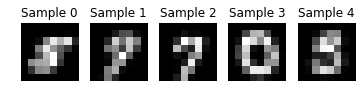

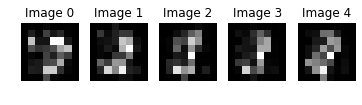

Epoch: 2 / G Loss: -0.21625 / D Loss: 0.00629112


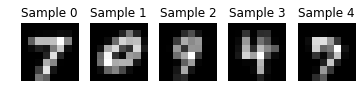

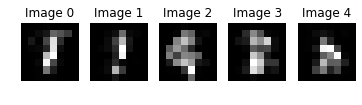

Epoch: 3 / G Loss: -0.23128 / D Loss: -0.0016315


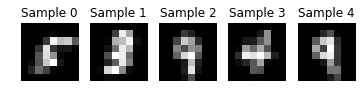

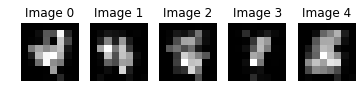

Epoch: 4 / G Loss: -0.24005 / D Loss: -0.0002313


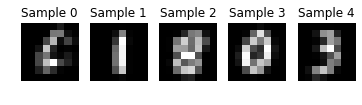

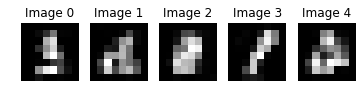

Epoch: 5 / G Loss: -0.26779 / D Loss: 0.00453113


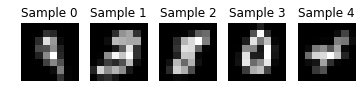

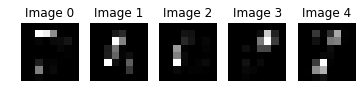

Epoch: 6 / G Loss: -0.23446 / D Loss: -0.002001


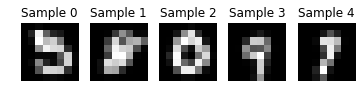

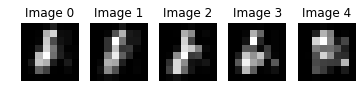

Epoch: 7 / G Loss: -0.26682 / D Loss: 0.0038111


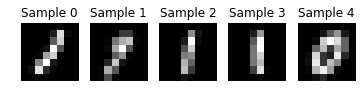

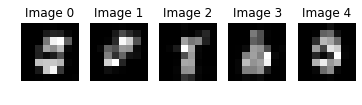

Epoch: 8 / G Loss: -0.24501 / D Loss: -0.001765


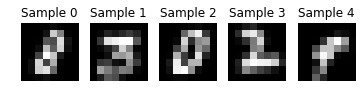

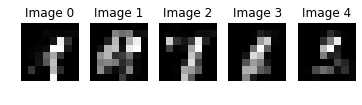

Epoch: 9 / G Loss: -0.26868 / D Loss: -0.001151


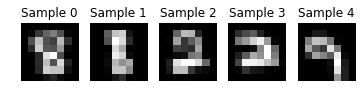

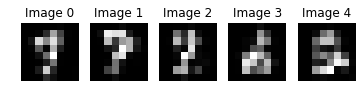

Epoch: 10 / G Loss: -0.25547 / D Loss: -0.00303


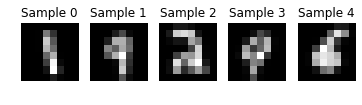

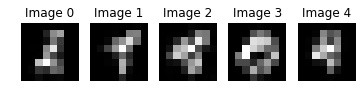

Epoch: 11 / G Loss: -0.25130 / D Loss: 0.00305


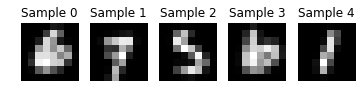

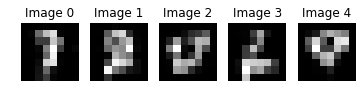

Epoch: 12 / G Loss: -0.24414 / D Loss: 0.00380


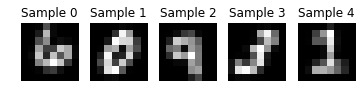

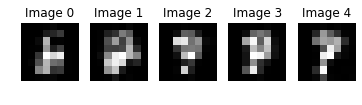

Epoch: 13 / G Loss: -0.25161 / D Loss: 0.00082


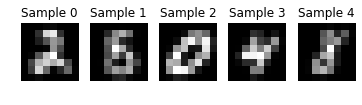

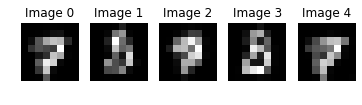

Epoch: 14 / G Loss: -0.26043 / D Loss: 0.00518


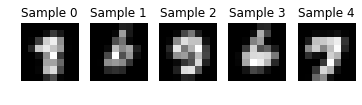

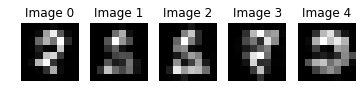

Epoch: 15 / G Loss: -0.23284 / D Loss: -0.00225


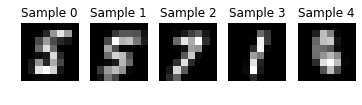

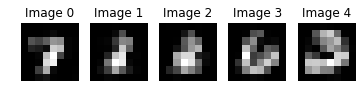

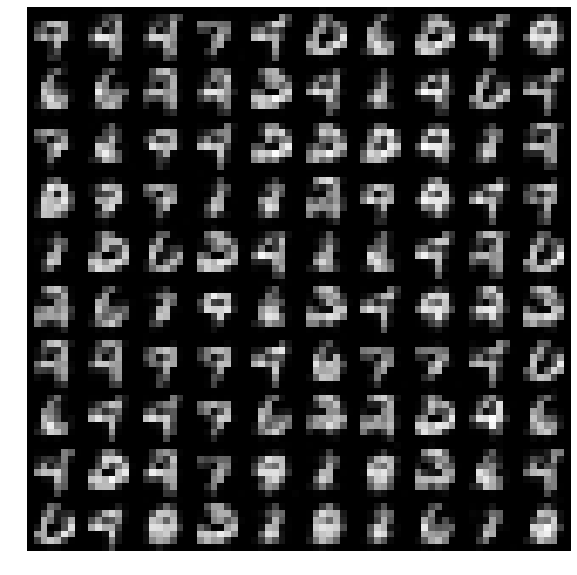


------------------ Level 0 is DONE!! ------------------

------------------- Var Assign is Finished! -------------------
Epoch: 1 / G Loss: -0.35601 / D Loss: -0.027396656


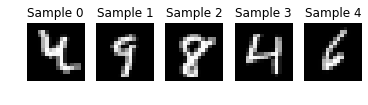

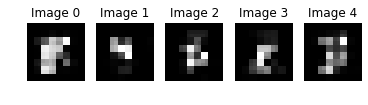

Epoch: 2 / G Loss: -0.34663 / D Loss: -0.0022466


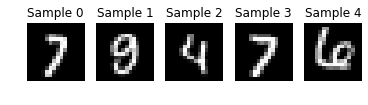

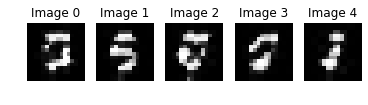

Epoch: 3 / G Loss: -0.43214 / D Loss: 0.04384666


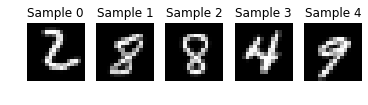

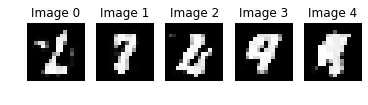

Epoch: 4 / G Loss: -0.35383 / D Loss: -0.0243466


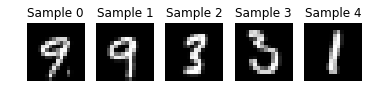

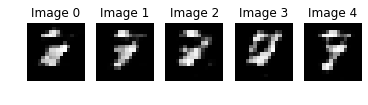

Epoch: 5 / G Loss: -0.50174 / D Loss: -0.0101565


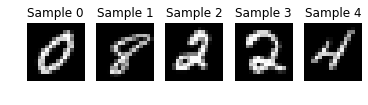

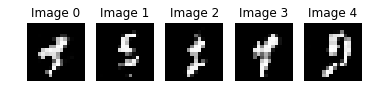

Epoch: 6 / G Loss: -0.40919 / D Loss: -0.0185465


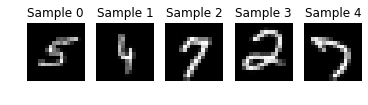

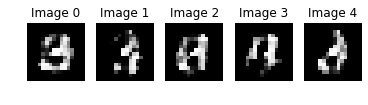

Epoch: 7 / G Loss: -0.39001 / D Loss: 0.02303665


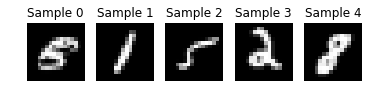

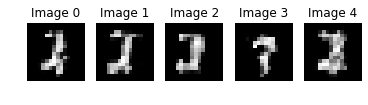

Epoch: 8 / G Loss: -0.50013 / D Loss: -0.0073565


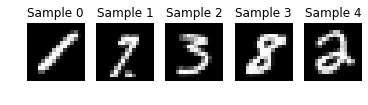

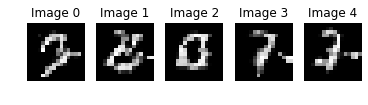

Epoch: 9 / G Loss: -0.34789 / D Loss: -0.0005167


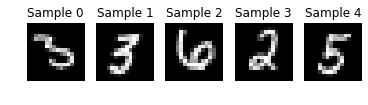

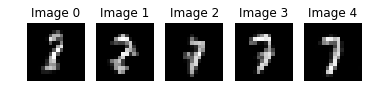

Epoch: 10 / G Loss: -0.44795 / D Loss: 0.003696


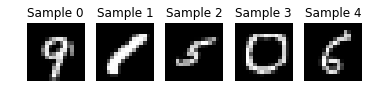

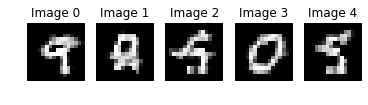

Epoch: 11 / G Loss: -0.40616 / D Loss: 0.015707


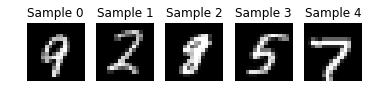

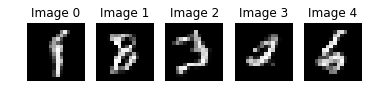

Epoch: 12 / G Loss: -0.41874 / D Loss: 0.004427


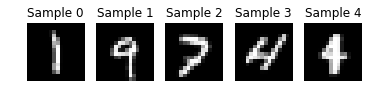

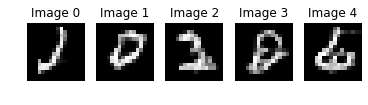

Epoch: 13 / G Loss: -0.38320 / D Loss: -0.00497


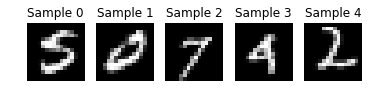

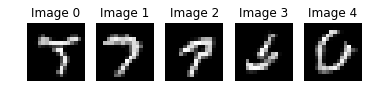

Epoch: 14 / G Loss: -0.40838 / D Loss: 0.012886


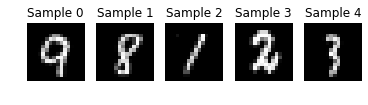

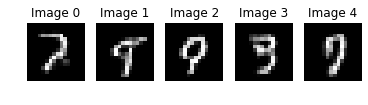

Epoch: 15 / G Loss: -0.42114 / D Loss: 0.031017


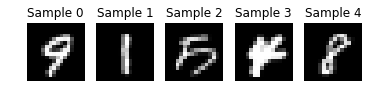

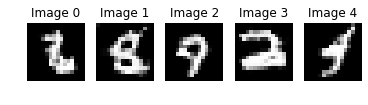

Epoch: 16 / G Loss: -0.41164 / D Loss: -0.01033


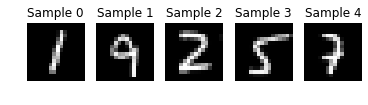

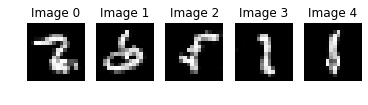

Epoch: 17 / G Loss: -0.36700 / D Loss: 0.011526


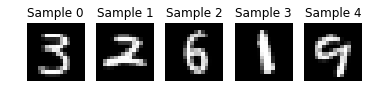

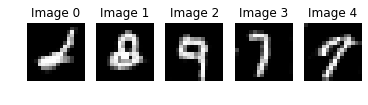

Epoch: 18 / G Loss: -0.34912 / D Loss: 0.00042


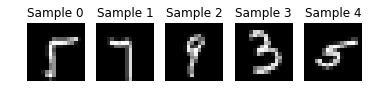

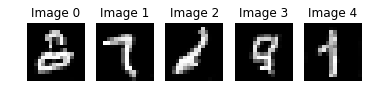

Epoch: 19 / G Loss: -0.42222 / D Loss: -0.00321


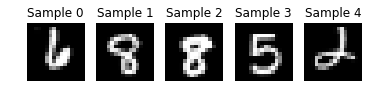

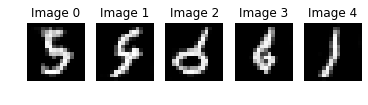

Epoch: 20 / G Loss: -0.45835 / D Loss: 0.00033


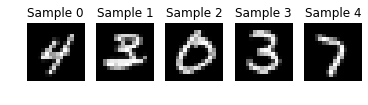

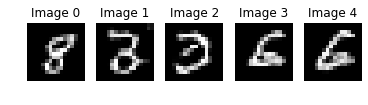

Epoch: 21 / G Loss: -0.42095 / D Loss: -0.00096


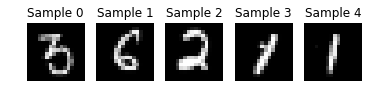

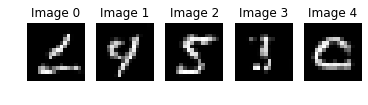

Epoch: 22 / G Loss: -0.46625 / D Loss: -0.00348


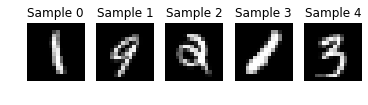

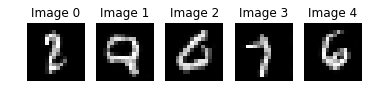

Epoch: 23 / G Loss: -0.38570 / D Loss: 0.00400


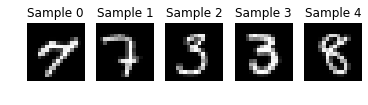

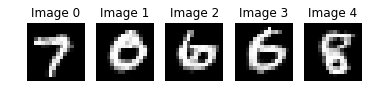

Epoch: 24 / G Loss: -0.25534 / D Loss: 0.01406


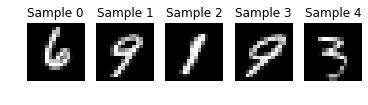

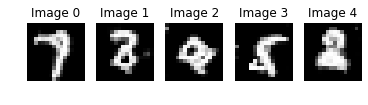

Epoch: 25 / G Loss: -0.41046 / D Loss: 0.00690


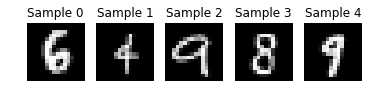

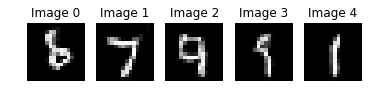

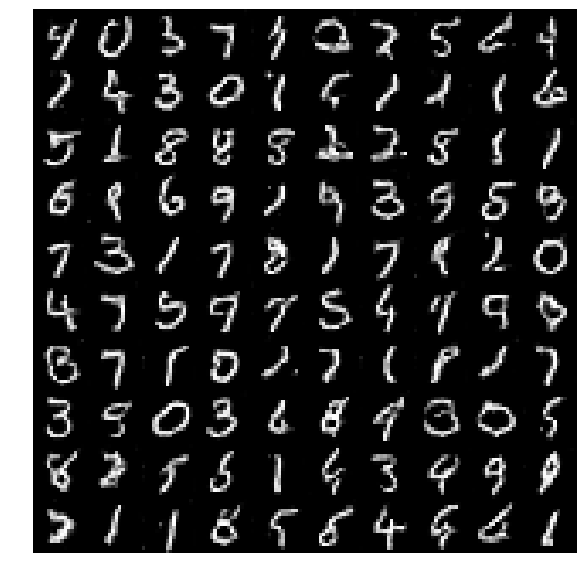


------------------ Level 1 is DONE!! ------------------

------------------- Var Assign is Finished! -------------------
Epoch: 1 / G Loss: -1.07755 / D Loss: 0.0060295236


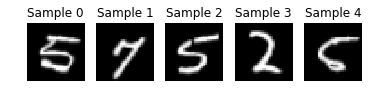

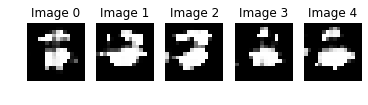

Epoch: 2 / G Loss: -0.94087 / D Loss: -0.03113385


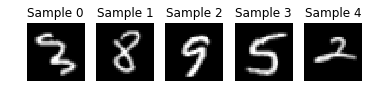

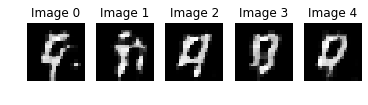

Epoch: 3 / G Loss: -1.14186 / D Loss: -0.0360723


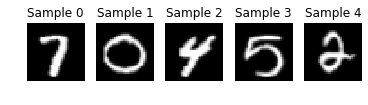

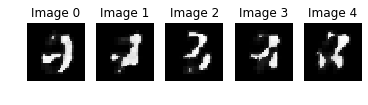

Epoch: 4 / G Loss: -0.78315 / D Loss: -0.0483408


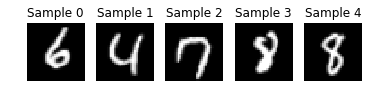

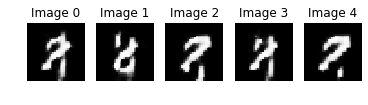

Epoch: 5 / G Loss: 0.28596 / D Loss: -0.11105095


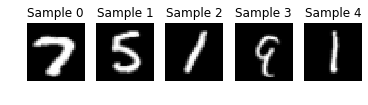

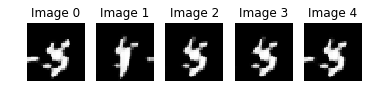

Epoch: 6 / G Loss: -0.57402 / D Loss: -0.1984586


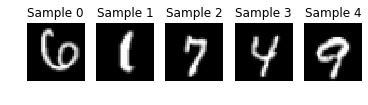

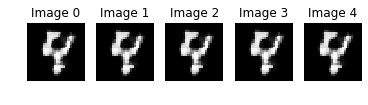

Epoch: 7 / G Loss: 0.34750 / D Loss: -0.15689666


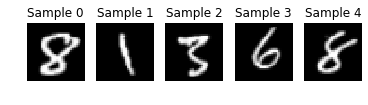

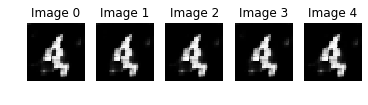

Epoch: 8 / G Loss: 0.67227 / D Loss: -0.24259954


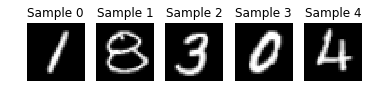

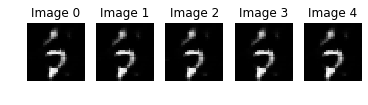

Epoch: 9 / G Loss: -0.69362 / D Loss: -0.3228945


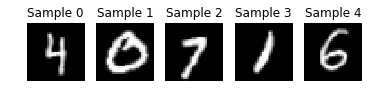

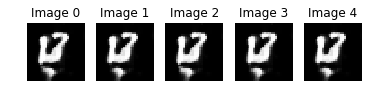

Epoch: 10 / G Loss: -0.88312 / D Loss: -0.311325


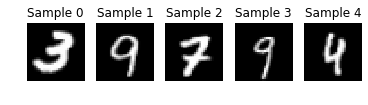

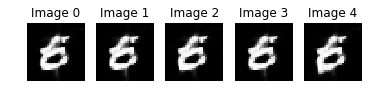

Epoch: 11 / G Loss: -1.30662 / D Loss: -0.003237


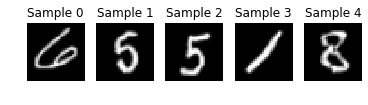

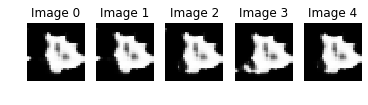

Epoch: 12 / G Loss: 0.12404 / D Loss: -0.4951497


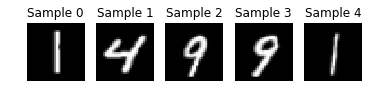

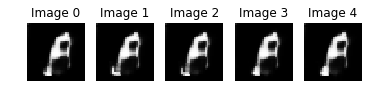

Epoch: 13 / G Loss: 1.25832 / D Loss: -0.661598


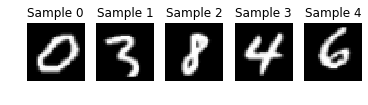

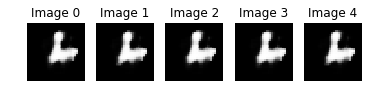

Epoch: 14 / G Loss: -0.72111 / D Loss: -0.43308


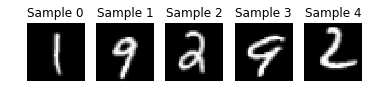

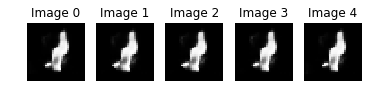

Epoch: 15 / G Loss: 1.16060 / D Loss: -0.305975


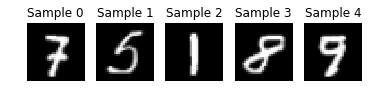

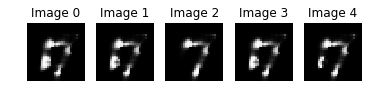

Epoch: 16 / G Loss: 1.43181 / D Loss: -0.310595


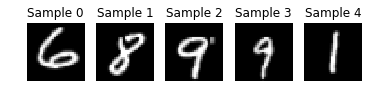

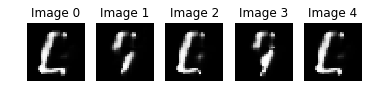

Epoch: 17 / G Loss: -0.94327 / D Loss: -0.28586


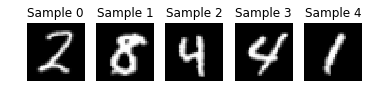

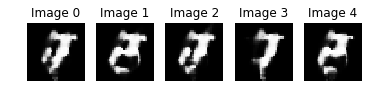

Epoch: 18 / G Loss: 0.00420 / D Loss: -0.007211


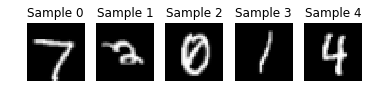

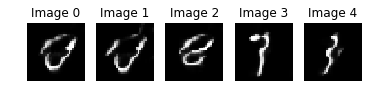

Epoch: 19 / G Loss: -0.18896 / D Loss: -0.28035


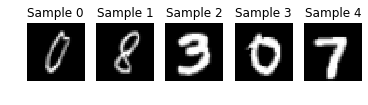

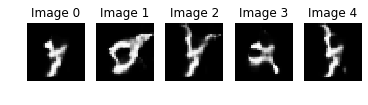

Epoch: 20 / G Loss: -0.65839 / D Loss: -0.03877


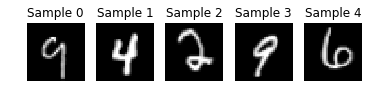

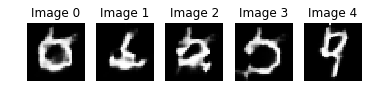

Epoch: 21 / G Loss: -1.45807 / D Loss: -0.06178


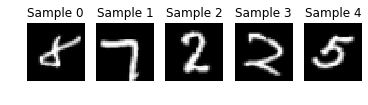

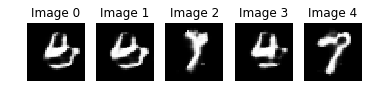

Epoch: 22 / G Loss: 0.15787 / D Loss: -0.069326


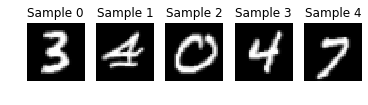

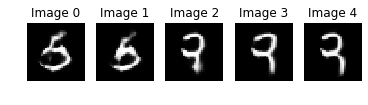

Epoch: 23 / G Loss: -0.90391 / D Loss: -0.04849


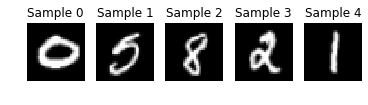

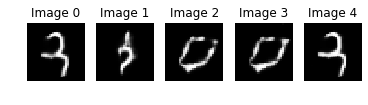

Epoch: 24 / G Loss: -1.33619 / D Loss: -0.06441


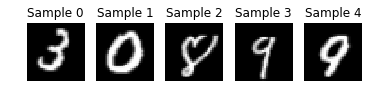

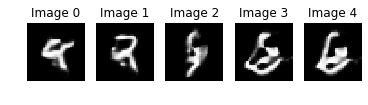

Epoch: 25 / G Loss: -0.46719 / D Loss: -0.12847


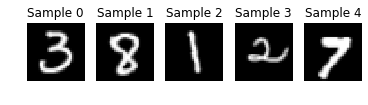

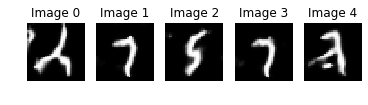

Epoch: 26 / G Loss: -1.49807 / D Loss: -0.05541


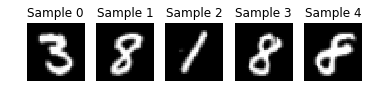

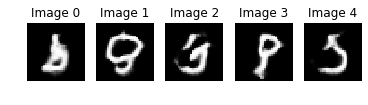

Epoch: 27 / G Loss: -1.58642 / D Loss: 0.05524


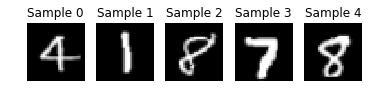

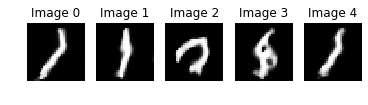

Epoch: 28 / G Loss: -1.72796 / D Loss: -0.00512


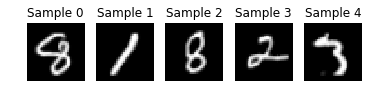

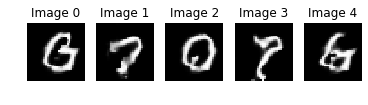

Epoch: 29 / G Loss: -0.98232 / D Loss: -0.05331


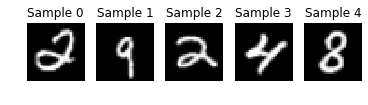

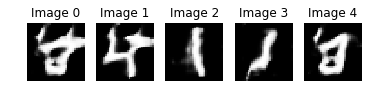

Epoch: 30 / G Loss: -0.36514 / D Loss: -0.09447


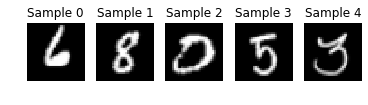

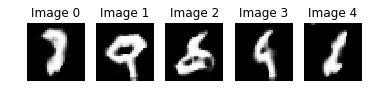

Epoch: 31 / G Loss: -1.77666 / D Loss: 0.00486


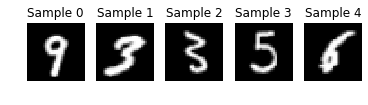

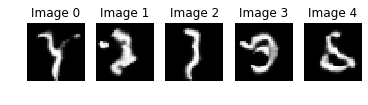

Epoch: 32 / G Loss: -2.04679 / D Loss: 0.01765


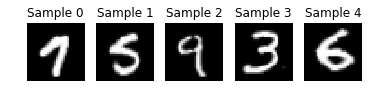

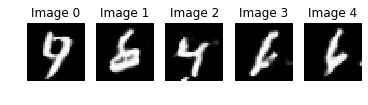

Epoch: 33 / G Loss: -0.77743 / D Loss: -0.13957


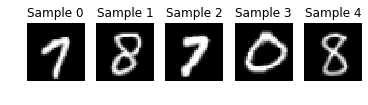

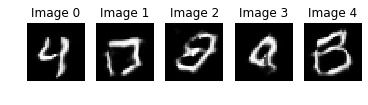

Epoch: 34 / G Loss: -1.10645 / D Loss: -0.14583


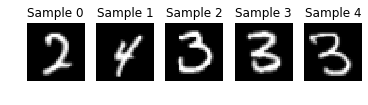

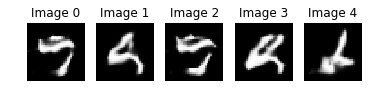

Epoch: 35 / G Loss: -0.95682 / D Loss: -0.06151


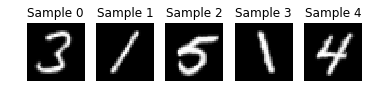

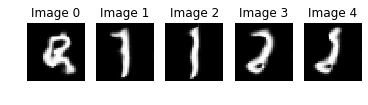

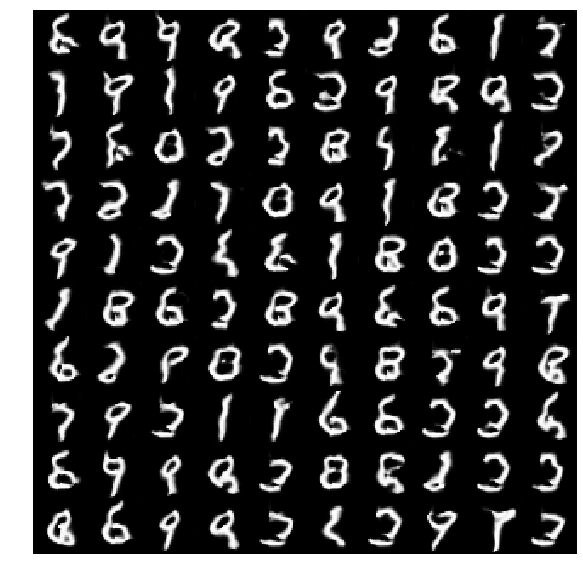


------------------ Level 2 is DONE!! ------------------



In [10]:
if train_model:
    # Training
    data_x = x_train
    len_data = x_train.shape[0]

    for m in range(len(size_list)):
        # Define models and set parameters for new level
        model = model_list[m]
        alpha = 0
        
        batch_size = batch_list[m]
        epoch = epoch_list[m]
        
        # Assign the parameters to the new layers
        if m != 0:
            model_var_d = model.trainable_vars_d
            model_var_g = model.trainable_vars_g
            
            model_old_var_d = model_old.trainable_vars_d
            model_old_var_g = model_old.trainable_vars_g
            
            for var_d in model_var_d:
                var_d_split = var_d.name.split('/')
                for var_old_d in model_old_var_d:
                    var_old_d_split = var_old_d.name.split('/')
                    
                    if var_d_split[1] == var_old_d_split[1] and var_d_split[2] == var_old_d_split[2]:
                        sess.run(var_old_d.assign(var_d))

            for var_g in model_var_g:
                var_g_split = var_g.name.split('/')
                for var_old_g in model_old_var_g:
                    var_old_g_split = var_old_g.name.split('/')
                    
                    if var_g_split[1] == var_old_g_split[1] and var_g_split[2] == var_old_g_split[2]:
                        sess.run(var_old_g.assign(var_g))
            
            print('------------------- Var Assign is Finished! -------------------')
        for i in range(epoch):
            # Shuffle the data 
            np.random.shuffle(data_x)
            
            # Get alpha for weighting the new layers 
#             alpha = 1.2*np.exp(i/epoch)-1
#             alpha = 1.2*i/epoch

#             if alpha > 1:
#                 alpha = 1.0
            
            # Making mini-batch
            for j in range(0, len_data, batch_size):
                alpha = 1.5* i/epoch + (1/epoch) * (j / len_data)
                
                if alpha > 1:
                    alpha = 1.0
                
                if j + batch_size < len_data:
                    x_in = data_x[j : j + batch_size, :]

                x_in = x_in.reshape((-1, img_size, img_size, 1))
                
                x_in_resize = np.zeros([x_in.shape[0], size_list[m], size_list[m], 1])
                
                for k in range(x_in.shape[0]):
                    x_in_resize[k,:,:,:] = resize(x_in[k,:,:,:], (size_list[m], size_list[m]))
                    
                sampled_z = np.random.uniform(-1, 1, size=(x_in_resize.shape[0] , n_latent))              
                
                # Run Optimizer!
                _, loss_d = sess.run([model.train_step_d, model.d_loss], feed_dict = {model.x: x_in_resize, 
                                                                                      model.z: sampled_z,
                                                                                      model.is_training: True,
                                                                                      model.alpha: [alpha],
                                                                                      model.batch_size: batch_size})
                _, loss_g = sess.run([model.train_step_g, model.g_loss], feed_dict = {model.x: x_in_resize, 
                                                                                      model.z: sampled_z, 
                                                                                      model.is_training: True,
                                                                                      model.alpha: [alpha],
                                                                                      model.batch_size: batch_size})

                print("Batch: {} / {}, alpha: {}".format(j, len_data, alpha), end="\r")

            # Print Progess
            print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

            # Show test images 
            z_test = np.random.uniform(-1, 1, size=(5, n_latent))
            G_out = sess.run(model.G, feed_dict = {model.z: z_test, model.is_training: False, 
                                                   model.alpha: [alpha], model.batch_size: 5})

            if i == 0 or (i+1) % show_result_epoch == 0:
                f1, ax1 = plt.subplots(1,5)
                for j in range(5):
                    ax1[j].imshow(x_in_resize[j,:,:,0], cmap = 'gray')
                    ax1[j].axis('off')
                    ax1[j].set_title('Sample '+str(j))
                    
            if i == 0 or (i+1) % show_result_epoch == 0:
                f2, ax2 = plt.subplots(1,5)
                for j in range(5):
                    ax2[j].imshow(G_out[j,:,:,0], cmap = 'gray')
                    ax2[j].axis('off')
                    ax2[j].set_title('Image '+str(j))

            plt.show()
        
        # Test Result of Each Level
        num_test = 10

        img = np.zeros([size_list[m] * num_test, size_list[m] * num_test])

        z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
        G_result = sess.run(model.G, feed_dict = {model.z: z_result, model.is_training: False, 
                                                  model.alpha: [1.0], model.batch_size: num_test**2})

        for i in range(num_test**2):
            row_num = int(i/num_test)
            col_num = int(i%num_test)

            img[row_num * size_list[m] : (row_num + 1) * size_list[m], 
                (col_num) * size_list[m] : (col_num + 1) * size_list[m]] = G_result[i,:,:,0]

        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

        model_old = model
        
        print('\n------------------ Level {} is DONE!! ------------------\n'.format(m))

## Image Generation

In [11]:
num_test = 10

img = np.zeros([size_list[-1] * num_test, size_list[-1] * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(model.G, feed_dict = {z: z_result})

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = G_result[i,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

NameError: name 'z' is not defined

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))